In [2]:
%pylab
%load_ext autoreload
%autoreload 2

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
from numpy import uint8, array
import matplotlib.pyplot as plt

In [5]:
from metric import tests
import cv2, tqdm
from utils import wand_transforms
import wand
from wand.image import Image
from metric.separate_iou import siou
from sklearn.metrics import pairwise_distances, adjusted_rand_score
import seaborn as sns
sns.set()

In [8]:
lst = ['niou', 'ari', 'f0_ari', 'f1_ari', 'ff_ari', 'siou_normal', 'siou_prop', 'siou_inv']
results_vs_N = {k:[] for k in lst}

for N in tqdm.trange(1, 15):
    results = {k:[] for k in lst}

    for i in range(100):
        circs = tests.uniform_random_circles(25, 55, 450, 10, 50, 5)
        XY = np.array([c for c, r in circs])
        rs = np.array([r for c, r in circs])
        dist = pairwise_distances(XY)
        dist -= rs[None, :]
        dist -= rs[:, None]
        np.fill_diagonal(dist, 'inf')

        nrs = rs.copy()
        for j in range(N):
            c1, c2 = np.unravel_index(dist.argmin(), dist.shape)
            pad = int((dist[c1, c2]/2))+1
            dist[c1, c2] = float('inf')
            dist[c2, c1] = float('inf')
            nrs[c1] = max(nrs[c1], rs[c1]+pad)
            nrs[c2] = max(nrs[c2], rs[c2]+pad)

        slices = np.zeros((25, 512, 512), np.uint8)
        image = np.zeros((512, 512), np.uint8)
        
        for j, (c, r) in enumerate(circs):
            slices[j] = cv2.circle(slices[j], c, r, 1, -1)
            image = cv2.circle(image, c, nrs[j], 1, -1)
        
        image = (image >= 1).astype(uint8)
        for normalize in ['normal', 'prop', 'inv']:
            results['siou_'+normalize].append(siou(image, slices, normalize=normalize))
            
        orig = slices.sum(0).astype(uint8)
        _, x = cv2.connectedComponents(orig, connectivity=8)
        _, y = cv2.connectedComponents(image, connectivity=8)
        results['ari'].append(adjusted_rand_score(x.reshape(-1), y.reshape(-1)))

        idx = orig != 0
        results['f0_ari'].append(adjusted_rand_score(x[idx], y[idx]))

        idx = image != 0
        results['f1_ari'].append(adjusted_rand_score(x[idx], y[idx]))

        idx = (orig != 0) | (image != 0)
        results['ff_ari'].append(adjusted_rand_score(x[idx], y[idx]))

        orig = orig.astype(bool)
        image = image.astype(bool)
        results['niou'].append((orig&image).sum()/(orig|image).sum())
    
    for k in lst:
        ar = np.array(results[k])
        mean, std = ar.mean(), ar.std()
        results_vs_N[k].append(mean)


100%|██████████| 14/14 [05:50<00:00, 24.69s/it]


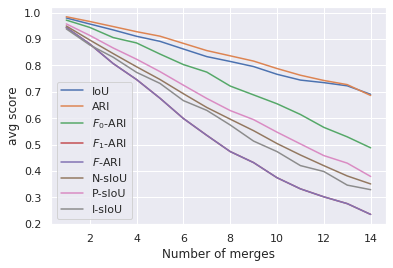

In [16]:
%matplotlib inline
lst2 = ['IoU', 'ARI', '$F_0$-ARI', '$F_1$-ARI', '$F$-ARI', 'N-sIoU', 'P-sIoU', 'I-sIoU']
plt.figure()
for k, l in zip(lst, lst2):
    y = results_vs_N[k]
    plt.plot(np.arange(len(y))+1, y, label=l)
plt.legend()
plt.xlabel("Number of merges")
plt.ylabel("avg score")
plt.savefig('/tmp/plot.png')


In [ ]:
results_vs_N['ff_ari']